<a href="https://colab.research.google.com/github/emmanuellfc/EM_Tufts_Fall2023/blob/main/GeneralFiniteDifferences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Package dependencies.
!apt install libcgal-dev libeigen3-dev
!pip install -U pygalmesh
!pip install networkx

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgmp-dev libgmpxx4ldbl libmpfr-dev
Suggested packages:
  libmpfi-dev libntl-dev libeigen3-doc libmpfrc++-dev gmp-doc libgmp10-doc libmpfr-doc
The following NEW packages will be installed:
  libcgal-dev libeigen3-dev libgmp-dev libgmpxx4ldbl libmpfr-dev
0 upgraded, 5 newly installed, 0 to remove and 11 not upgraded.
Need to get 6,457 kB of archives.
After this operation, 52.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgmpxx4ldbl amd64 2:6.2.1+dfsg-3ubuntu1 [9,580 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgmp-dev amd64 2:6.2.1+dfsg-3ubuntu1 [337 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmpfr-dev amd64 4.1.0-3build3 [271 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcgal-dev amd64 5.4-1 [4,784 kB]
Get:5 http://archive.u

In [3]:
# Imports.
import pygalmesh
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.colormaps as cmaps
from typing import Iterable
from typing import Callable
from typing import Optional
import math

In [23]:
# Rperesents an individual node of the graph data structure representation of the mesh.
class MeshPoint: pass
class MeshPoint:
  def __init__(self,pos: tuple = (0,0)):
    self.pos = tuple(pos) # (x,y) position of the node.
    self.pot: Optional[float] = None # Solution of potential for this node point.
    self.is_boundary = False # Is this node associated with a boundary condition?
  def __getitem__(self,index):
    return self.pos[index]
  def __eq__(self,other: MeshPoint):
    return self.pos is other.pos
  def __hash__(self):
    return hash(self.pos)

  # The "gamma" function is one half the sum of inverse square distances between these points. i.e. 0.5(1/(x1-x2)^2 + 1/(y1-y2)^2).
  def gamma(self,other: MeshPoint) -> float:
    if  len(self.pos) is not len(other.pos):
      raise Exception('Incompatable dimensionality computing gamma: ' + self.pos + ' and ' + other.pos)
    tmp: float = 0
    for dim in range(len(self.pos)):
      # Don't divide by 0.
      if math.isclose(self.pos[dim],other.pos[dim]): continue
      tmp += pow(self.pos[dim]-other.pos[dim],-2)
    return tmp/2

# Represents a mesh (contains a graph) for the system we're trying to solve.
class FiniteDifferences:
  def __init__(self):
    self.boundary_conditions: Callable[[MeshPoint],Optional[float]] = None # A function that takes a node and if boundary node: return pot; else: return None.
    self.edge_points: list = None # List of (x,y) points that form the boundary of the 2D space.
    self.mesh = None # Pygalmesh mesh object.
    self.mesh_points: list = None # List of non-boundary condition MeshPoints that form the region of 2D space.
    self.dirichlet_points: list = None # List of MeshPoints that are boundary condition points (only Dirichlet points).
    self.all_points: list = None # Simply self.mesh_points + self.dirichlet_points after they're constructed.
    self.graph = nx.Graph() # Graph data structure representing the region. Nodes of the graph are MeshPoint objects.
    self.systems_matrix = None # m x m matrix where m is the number of non-boundary points in the space. (m is how many points we need to solve for.)
    self.systems_rhs = None # m x 1 vector that serves as the right hand side of the system of linear equations.
    self.solution = None # Solution result of the systems matrix (m x 1 vector).

  # Inform the method of boundary conditions that exist for the problem.
  # We expect a function that takes a MeshPoint object and returns a boundary potential for it if it should have one. Expects None for "not a boundary point."
  def inform_with_boundary_conditions(self,conditions: Callable[[MeshPoint],Optional[float]]):
    self.boundary_conditions = conditions

  # Make a list of points from some edge conditions. This makes a surface "mesh" from a boundary definition. The boundary is a list of points.
  def make_points_from_boundary(self,boundary: Iterable[tuple]):
    if self.boundary_conditions is None:
      raise Exception('Error: Need to inform with boundary conditions before providing boundary points.')
    # First, store the edge points that we were passed.
    self.edge_points = list(boundary)
    # The constraints we pass to pygalmesh need to look like [(0,1),(1,2),...(n-2,n-1),(n-1,0)]. The last constraint closes the boundary.
    constraints = [ (i-1,i) for i in range(1,len(self.edge_points)) ] + [(len(self.edge_points)-1,0)]
    # Ask pygalmesh to make a mesh for us.
    self.mesh = pygalmesh.generate_2d(
      self.edge_points,
      constraints,
      max_edge_size=4e-1,
      num_lloyd_steps=10,
    )
    # Store the points as MeshPoint objects.
    self.mesh_points = []
    self.dirichlet_points = []
    for pt in self.mesh.points:
      mesh_point = MeshPoint(pt)
      boundary_result = self.boundary_conditions(mesh_point)
      mesh_point.is_boundary = not boundary_result is None
      if mesh_point.is_boundary:
        mesh_point.pot = boundary_result
        self.dirichlet_points.append(mesh_point)
      else:
        self.mesh_points.append(mesh_point)
    # Sanity checks: These lists shouldn't ever be empty.
    if not self.mesh_points: raise Exception('Error: Mesh point list is empty.')
    if not self.dirichlet_points: raise Exception('Error: Boundary condition point list is empty.')
    # Build the convenience list that's the concactenation of the non-boundary and boundary lists.
    self.all_points = self.mesh_points + self.dirichlet_points

  # Only callable once a mesh exists. Build a graph data structure from a list of points. Don't make neighbors out of points that are too far away.
  def make_graph_from_points(self):
    # First, add all mesh points to the graph as nodes.
    for point in self.all_points:
      self.graph.add_node(point)
    # Now, for each point...
    for point in self.all_points:
      # Get gamma values for all of the other points...
       # This makes a copy of our point list with the closest gamma points first. NEARER points have LARGER gamma values.
      points_gammas = sorted(self.all_points,key=lambda other_point: point.gamma(other_point),reverse=True)
      # Keep the nearest 10 points... TODO: Make this more general/parametrized?
      # Add edges between this point and "nearby" points.
      for other_point in points_gammas[:3]:
        if point == other_point: continue # Don't try to link a point to itself! (This shouldn't really be possible.)
        # Make the edge between these points.
        self.graph.add_edge(point,other_point,gamma=point.gamma(other_point))

  # Only callable once a graph exists. Make the C matrix element by element.
  def make_systems_matrix(self):
    # Initialize the systems matrix to the correct size (m x m where m is our number of non-boundary points, that is, the matrix is only necessary for points we're solving for).
    m = len(self.all_points)
    self.systems_matrix = np.array([np.zeros(m) for j in range(0,m)])
    self.systems_rhs = np.zeros(m)
    # c_{i,i} = -1, so fill that diagonal now.
    for i in range(0,m): self.systems_matrix[i][i] = -1
    # Iterate over nodes of the graph...
    for i_point,point in enumerate(self.all_points):
      if point.is_boundary: # For boundary nodes, the row should only have the diagonal element set, and this forms the equation x_i = pot_i. (This is a Dirichlet condition.)
        self.systems_matrix[ i_point ][ i_point ] = 1
        # The RHS for this index needs to be set to the pot to finish this boundary condition.
        self.systems_rhs[ i_point ] = point.pot
        continue
      # Condition for if this is NOT a boundary point (one we need to solve for).
      # ... and get the edges for this point (its neighbors).
      # For each of these, c_{i,j} = gamma_{i,j} / (k el neighbors(i) sum gamma_{i,k}).
      # self.graph[point] is a dict of { neighbor_point : attributes } elements. We expect attributes to contain a gamma attribute.
      neighbors = self.graph[point]
      # First get the gamma sum for this point (depends on all neighbors).
      gamma_sum: float = 0
      for neighbor in neighbors:
        gamma_sum += self.graph[point][neighbor]['gamma']
      # Iterate over neighbors now and fill in c_{i,j} elements.
      for neighbor in neighbors:
        # What is the index of the neighbor?
        i_neighbor = self.all_points.index(neighbor)
        self.systems_matrix[ i_point ][ i_neighbor ] = self.graph[point][neighbor]['gamma'] / gamma_sum

  # Only callable once a C matrix exists. Try to solve the C matrix.
  def solve_systems_matrix(self):
    self.solution = np.linalg.solve(self.systems_matrix,self.systems_rhs)
    # Store pot values in our mesh points themselves.
    for i_point,point in enumerate(self.all_points):
      point.pot = self.solution[i_point]

  # Profit???

[[-1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  2.29255364e-01
   2.70736679e-01  2.29262990e-01  2.70744967e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.00000000e+00  3.42390429e-03  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  2.39422053e-04  1.89622647e-04  0.00000000e+00
   7.13401674e-04  0.00000000e+00  5.65932136e-04  0.00000000e+00
   0.00000000e+00  0.00000000e+00  7.64625209e-04  0.00000000e+00
   4.96570599e-01  9.12094747e-04  4.96620398e-01]
 [ 0.00000000e+00  1.47451479e-01 -1.00000000e+00  0.00000000e+00
   1.47093727e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  9.51433062e-03  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.000

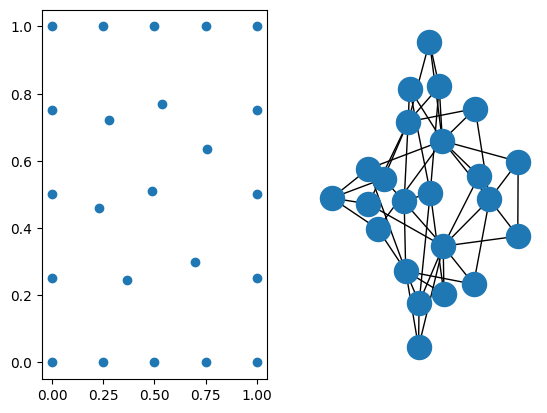

In [25]:
# Generate the simplest possible boundary: An edge length 1 box.
def box_generator():
  yield (0,0)
  yield (0,1)
  yield (1,1)
  yield (1,0)

# Declare boundary conditions. Take a point in, return a pot if this is a boundary node.
def stupid_boundary(point: MeshPoint) -> Optional[float]:
  if point.pos[0] < 0.05: return 10
  if point.pos[0] > 0.95: return 10
  if point.pos[1] < 0.05: return -10
  if point.pos[1] > 0.95: return -10
  return None

# Make a new solver object.
solution = FiniteDifferences()

# Tell it about our boundary condition function.
solution.inform_with_boundary_conditions(stupid_boundary)

# Have the solver sample points within the edges.
solution.make_points_from_boundary(box_generator())

# Visualize the distribution.
plt.subplot(121)
plt.scatter([ loc[0] for loc in solution.all_points ],[ loc[1] for loc in solution.all_points ])

# Form the internal graph data structure.
solution.make_graph_from_points()

plt.subplot(122)
nx.draw(solution.graph)

# Generate the systems matrix that represents the linear set of equations to solve.
solution.make_systems_matrix()

# Print the systems matrix and rhs vector.
#with np.printoptions(threshold=np.inf):
print(solution.systems_matrix)
print(solution.systems_rhs)

# Tell the solver to try and solve the systems matrix.
solution.solve_systems_matrix()

# Print the solution vector.
print(solution.solution)